In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
# Parameter windowing
input_width = 48
label_width = 48
shift = label_width
total_window_size = input_width + shift
OUT_STEPS = label_width
# Definisikan irisan untuk input dan label
input_slice = slice(0, input_width)
label_start = total_window_size - label_width
labels_slice = slice(label_start, None)

from A_template import  scale_array, inverse_scale_array, make_windows, process_predictions, compute_metrics, compute_error

In [ ]:
data= pd.read_excel('D:\\KULIAH S2\\Komputasi Lanjut\\TIMESERIES_CODE\\cuaca_bebanLR5_v2.xlsx', index_col=0)
data

,Beban,Hari_Khus,Jam_sin,Jam_cos,Hari_sin,Hari_cos,Hari_Khus_sin,Hari_Khus_cos,Tanggal_sin,Tanggal_cos,Bulan_sin,Bulan_cos
Date,,,,,,,,,,,,
2023-02-12 00:30:00,20312.00,0,0.130526,0.991445,-0.781831,0.62349,0.0,1.0,7.431448e-01,-0.669131,0.5,0.866025
2023-02-12 01:00:00,20180.00,0,0.258819,0.965926,-0.781831,0.62349,0.0,1.0,7.431448e-01,-0.669131,0.5,0.866025
2023-02-12 01:30:00,20021.00,0,0.382683,0.923880,-0.781831,0.62349,0.0,1.0,7.431448e-01,-0.669131,0.5,0.866025
2023-02-12 02:00:00,19906.00,0,0.500000,0.866025,-0.781831,0.62349,0.0,1.0,7.431448e-01,-0.669131,0.5,0.866025
2023-02-12 02:30:00,19743.00,0,0.608761,0.793353,-0.781831,0.62349,0.0,1.0,7.431448e-01,-0.669131,0.5,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 22:00:00,21241.27,0,-0.500000,0.866025,-0.781831,0.62349,0.0,1.0,-2.449294e-16,1.000000,-0.5,0.866025
2023-12-31 22:30:00,20800.42,0,-0.382683,0.923880,-0.781831,0.62349,0.0,1.0,-2.449294e-16,1.000000,-0.5,0.866025
2023-12-31 23:00:00,20450.02,0,-0.258819,0.965926,-0.781831,0.62349,0.0,1.0,-2.449294e-16,1.000000,-0.5,0.866025


In [3]:
df1=data.copy()
beban_scaled, beban_min, beban_max  =scale_array(df1['Beban'].values)
df1['Beban']=beban_scaled
input_make_windows=df1.drop(columns=["Beban"]).to_numpy()
output_make_windows=df1['Beban'].to_numpy()
x,y=make_windows(input_make_windows, output_make_windows,total_window_size, input_slice, labels_slice)

In [4]:
import tensorflow as tf

# Define the TimeDistributed model
model_td = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(48, 11)),  # 48 timesteps, 11 features per timestep
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(256, activation='tanh')),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(128, activation='tanh')),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1)),  # One prediction per timestep
    tf.keras.layers.Reshape((48,))  # Reshape output from (batch, 48, 1) to (batch, 48)
])

# Compile the model using an optimizer and a loss function appropriate for regression (MSE)
model_td.compile(optimizer='adam', loss='mse')

# Display model architecture summary
model_td.summary()

# Train the model
# X_train: shape (15409, 48, 11)
# Y_train: shape (15409, 48)
history = model_td.fit(
    x,        # Your input training data
    y,        # Your target training data
    batch_size=48*2,  # Number of samples per gradient update
    epochs=100,      # Number of training epochs
    validation_split=0.2,  # Reserve 20% of the data for validation
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)]
)

model_td.save('model_td_2.h5')


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 48, 256)          3072      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 48, 128)          32896     
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 48, 1)            129       
 tributed)                                                       
                                                                 
 reshape (Reshape)           (None, 48)                0         
                                                                 
Total params: 36,097
Trainable params: 36,097
Non-trainable params: 0
____________________________________________________

In [5]:
df_pred_act = compute_error(x, data['Beban'], ['Beban'], model_td, input_width,label_width, beban_min, beban_max)
df_pred_act

11/11 [==============================] - 0s 1ms/step
MAE: 684.8487996444544, MAPE %: 2.764179083286077, MSE: 1009485.7397673295, RMSE: 1004.7316755071124


,Prediksi,Aktual
Date,,
2023-02-13 00:30:00,20644.218750,19244.00
2023-02-13 01:00:00,20251.925781,19141.00
2023-02-13 01:30:00,19950.566406,18943.00
2023-02-13 02:00:00,19739.326172,18862.00
2023-02-13 02:30:00,19614.011719,18639.00
...,...,...
2023-12-31 22:00:00,23728.507812,21241.27
2023-12-31 22:30:00,23245.031250,20800.42
2023-12-31 23:00:00,22856.505859,20450.02


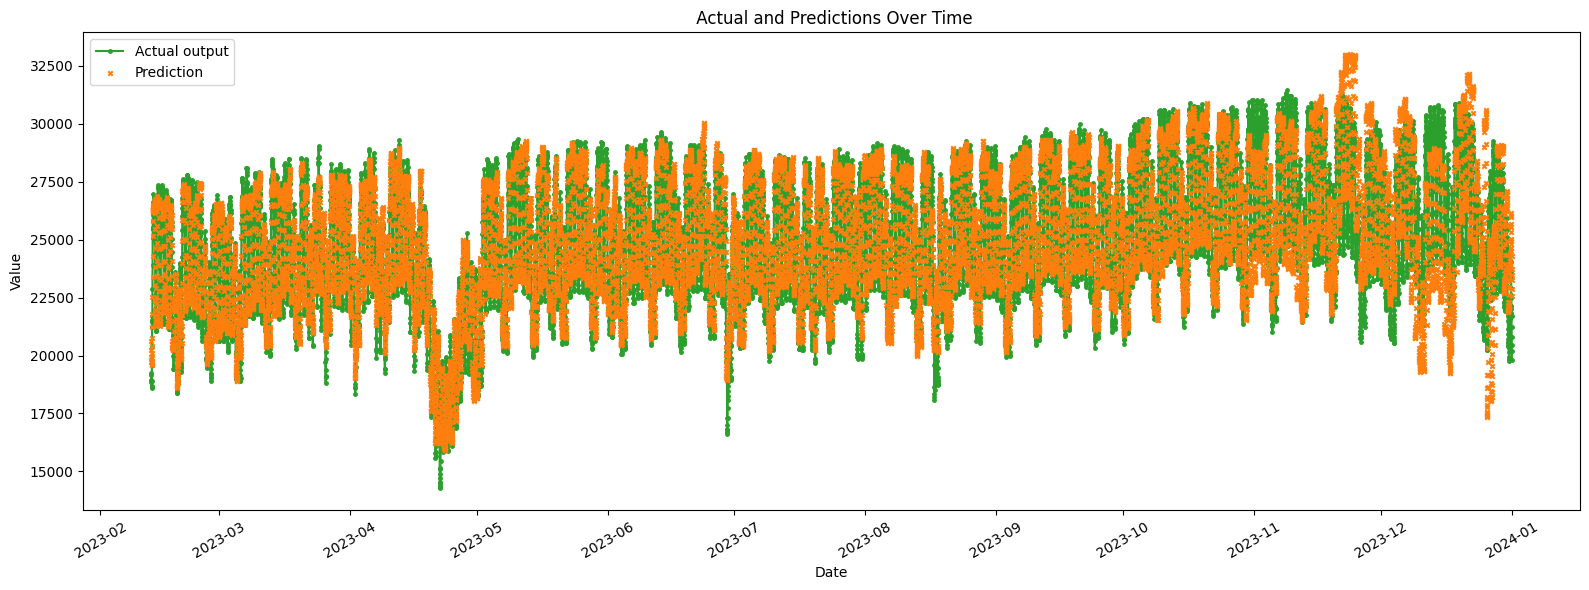

In [6]:
df= df_pred_act.copy()
plt.figure(figsize=(16, 6))

# Plot the "Actual" as a green line with dot markers
plt.plot(
    df.index, 
    df['Aktual'], 
    label='Actual output', 
    marker='.', 
    markersize=5, 
    color='#2ca02c', 
    zorder=-100
)

# Scatter plot for "Prediction" in orange X markers
plt.scatter(
    df.index, 
    df['Prediksi'], 
    marker='x', 
    #edgecolors='k', 
    label='Prediction', 
    c='#ff7f0e', 
    s=10
)


plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.xticks(rotation=30)
plt.title(' Actual and Predictions Over Time')
plt.tight_layout()
plt.show()
